INTRODUCTION

## Methods & Results: Loading in Libraries & Reading in Data

As always, before we begin coding, we must load the required libaries for R.

In [28]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(digest)
library(repr)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

Next, we will begin reading the file into JupyterHub. Since the file is retrieved from an outside URL, we will download the file to JupyterHub, and since the cells are seperated by semi-colons, instead of normally reading the file through read_csv, we will read the file by read_csv2.

In [29]:
#reading the data
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip",temp)

#Reading the data in R
facebook <- read_csv2(unz(temp, "dataset_Facebook.csv"))
head(facebook)
unlink(temp)

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  `Page total likes` = col_double(),
  Type = col_character(),
  Category = col_double(),
  `Post Month` = col_double(),
  `Post Weekday` = col_double(),
  `Post Hour` = col_double(),
  Paid = col_double(),
  `Lifetime Post Total Reach` = col_double(),
  `Lifetime Post Total Impressions` = col_double(),
  `Lifetime Engaged Users` = col_double(),
  `Lifetime Post Consumers` = col_double(),
  `Lifetime Post Consumptions` = col_double(),
  `Lifetime Post Impressions by people who have liked your Page` = col_double(),
  `Lifetime Post reach by people who like your Page` = col_double(),
  `Lifetime People who have liked your Page and engaged with your post` = col_double(),
  comment = col_double(),
  like = col_double(),
  share = col_double(),
  `Total Interactions` = col_double()
)



Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
139441,Photo,2,12,2,3,0,7244,13594,671,410,580,6228,3200,396,19,325,49,393
139441,Status,2,12,1,9,0,10472,20849,1191,1073,1389,16034,7852,1016,1,152,33,186


Figure 1: Initial Dataset of Table

Looking at our dataset, it passes the test for tidy data (each row is a single observation, each column is a single variable, each value is a single cell), so no further cleaning data tools are required. However, the variable names are separated by white spaces instead of underscores (_). To deal with this issue, we will rename our predictor columns to avoid additional headaches along the way. 

In [30]:
#Renaming "Post Hour"
facebook_1 <- facebook %>% rename(post_hour = `Post Hour`) %>% 
    rename(post_day = `Post Weekday`) %>% 
    rename(total_interactions = `Total Interactions`)

## Methods & Results: Exploratory Data Analysis and Splitting Data

As part of our exploratory data analysis, we'll take a quick overview of our predictor variable, plotting "Total Interactions" against a time variable (In this case, we'll use Post Hour) through a scatterplot, just to filter out any potential outliers in our data.

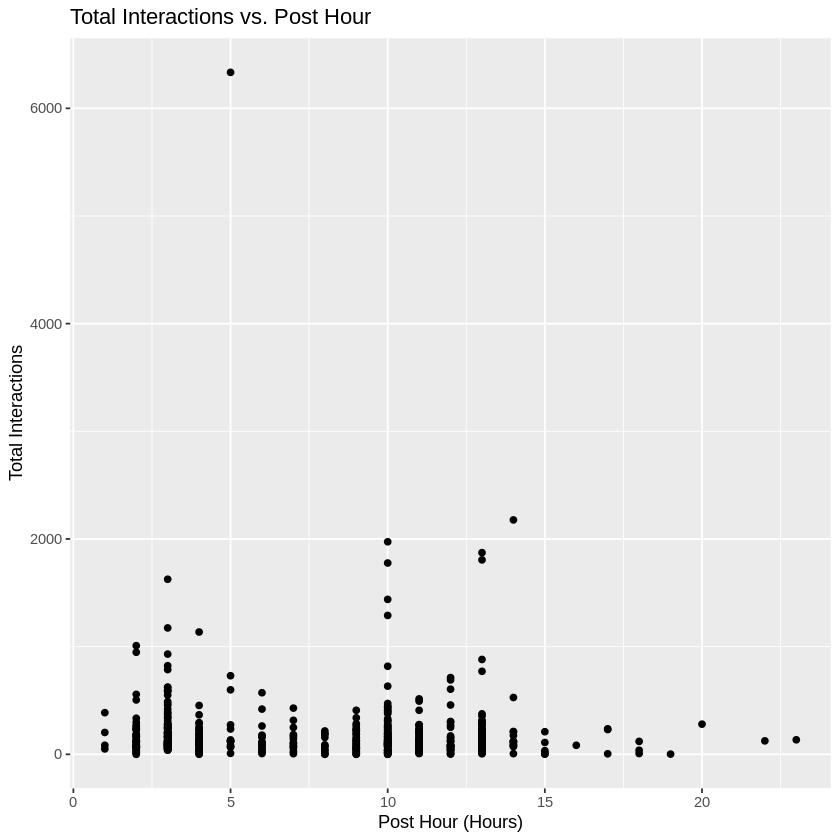

In [31]:
exploratory_scatter_plot <- ggplot(facebook_1, aes(x = post_hour, y = total_interactions)) +
                            geom_point() +
                            labs(x = "Post Hour (Hours)", y = "Total Interactions", title = "Total Interactions vs. Post Hour") 
exploratory_scatter_plot

Figure 2: Exploratory Scatter Plot

Hmmm. It seems here that there is one post that has more than six thousand total interactions, with only around ten posts that have more than a thousand total interactions. These outliers can cause implications as it can skew the results of our data (large standard deviations) and make our graph look silly, like in the example above. Therefore, let's filter our total interactions to be less than a thousand to retrieve the most optimal results when we perform our regression models. And as stated in our introduction, let's also create a new variable for the hour of the week through the mutate function.

In [32]:
set.seed(2021)
facebook_filtered2 <- facebook_1 %>% filter(total_interactions < 1000) %>% 
    mutate(hour_of_week = (post_day - 1) * 24 + post_hour)
facebook_filtered2

Page total likes,Type,Category,Post Month,post_day,post_hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,total_interactions,hour_of_week
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100,75
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164,58
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80,51
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
81370,Photo,1,1,5,2,0,3778,7216,625,572,795,4742,2388,363,4,93,18,115,98
81370,Photo,3,1,4,11,0,4156,7564,626,574,832,4534,2452,370,7,91,38,136,83
81370,Photo,2,1,4,4,NA,4188,7292,564,524,743,3861,2200,316,0,91,28,119,76


Figure  3: Filtering of Total Interactions and Addition of Post_Week Variable Table

Next, let's build our exploratory table of our training dataset that we will be performing our K-Nearest Neighbors Regression on, which includes the number of rows, the number of columns and the number of rows with missing data values. However, to find to the means to our predictor variables (likes, comments, shares, and our total interactions), we will also need to filter out the number of rows with missing data values, so that we would not encounter any problems (such as a "NA" result) when finding the average. Altogether, we will mutate each of the results we found into one big table in the end.

In [33]:
set.seed(2021)

#Filtering missing data
facebook_train_filtered <- facebook %>%
                           filter(!is.na(row))

#Missing Rows of Data
missing_rows <- sum(colSums(is.na(facebook)))

#Average of Each Predictor Variable
average_likes <- mean(facebook_train_filtered[["like"]])
average_comments <- mean(facebook_train_filtered[["comment"]])
average_shares <- mean(facebook_train_filtered[["share"]])
average_total_interactions <- mean(facebook_train_filtered[["total_interactions"]])

#Total Number of Observations
observation_total <- nrow(facebook_train_filtered)

#Total Number of Variables
variable_total <- ncol(facebook_train_filtered)

#Exploratory Data Analysis Table
exploratory_table <- facebook_train_filtered %>%
                     mutate(facebook_train_filtered, observation_total = observation_total) %>%
                     mutate(facebook_train_filtered, variable_total = variable_total) %>%
                     mutate(facebook_train_filtered, average_likes = average_likes) %>%
                     mutate(facebook_train_filtered, average_comments = average_comments) %>%
                     mutate(facebook_train_filtered, average_shares = average_shares) %>%
                     mutate(facebook_train_filtered, average_total_interactions = average_total_interactions) %>%
                     mutate(facebook_train_filtered, missing_rows = missing_rows) %>%
                     select(observation_total, variable_total, average_likes, average_comments, average_shares, average_total_interactions,
                            missing_rows) %>%
                     slice(1)
exploratory_table

Warning message in is.na(row):
“is.na() applied to non-(list or vector) of type 'closure'”
Warning message in mean.default(facebook_train_filtered[["total_interactions"]]):
“argument is not numeric or logical: returning NA”


observation_total,variable_total,average_likes,average_comments,average_shares,average_total_interactions,missing_rows
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
500,19,NA,7.482,NA,NA,6


Based on these results of our exploratory table, we can notice a few things. First off, there are 500 (MAY CHANGE) observations in total for our training dataset alone, which means that theres a lot of data to process for our K-NN regression algorithm model, which will mean that regardless of the amount of folds we specify for the cross validation, our accuracy for our model will not be perfect. Secondly, it will be important to keep in mind the average of the total interactions (175) eventually, when analyzing our predictor visualization.

Next, let's create a quick visualization of our dataset of our predictor and target variables (total interactions and hour of week) through the function ggpairs. 

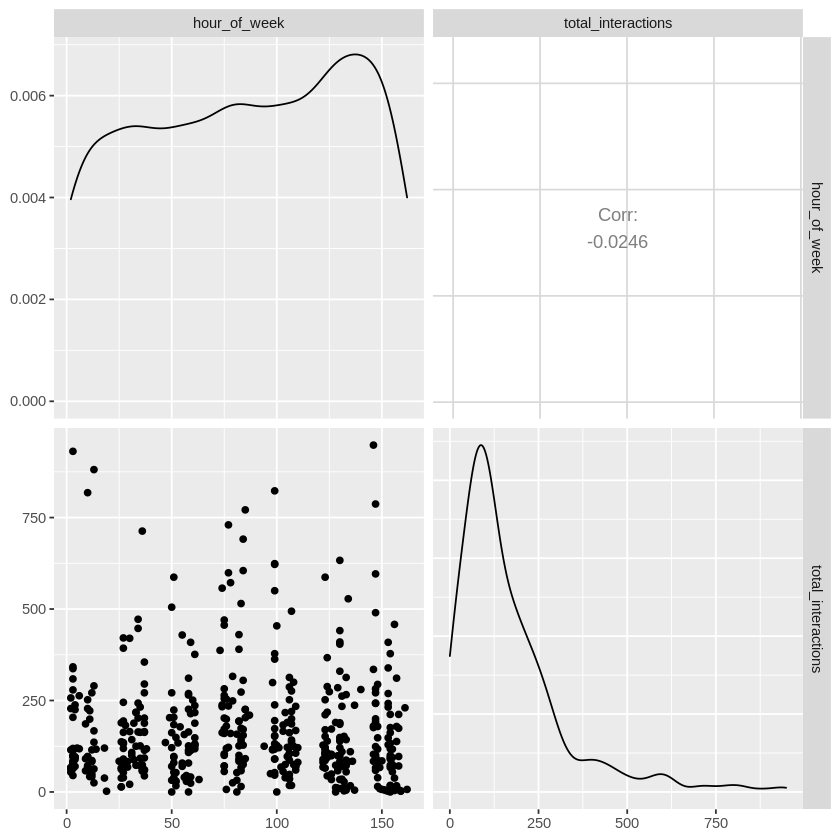

In [34]:
facebook_ggpairs2 <- facebook_filtered2 %>%
    select(hour_of_week, total_interactions) %>% 
    ggpairs()
facebook_ggpairs2

Figure  4: Ggpairs Dataset between Hour_of_Week and Total_Interactions  

Looking at the relationship between Hour of Week and Total Interactions, there seems to have no correlation between the two variables. This means as that as the week progresses, this does not affect the number of total interactions, and vice versa. While this may serve as an intial prediction, explore more affecing our results**

## Methods and Results: Predicting Highest Engagement based on Hour of Week

As we are clearly predicting a numerical value, this is a regression problem, predicting the highest engagement based on the hour of the week. As with any regression or classification model at the start, we'll split the data into training and testing data, setting aside 75 percent for the training data set and 25 percent with our testing data set, and setting our strata to be our target variable, which is total interactions.

In [4]:
#Split into training (75 percent of data set) and test data
set.seed(2021)
facebook_split <- initial_split(facebook_filtered2, prop = 0.75, strata = total_interactions)
facebook_train <- training(facebook_split)
facebook_test <- testing(facebook_split)

ERROR: Error in initial_split(facebook_filtered2, prop = 0.75, strata = total_interactions): could not find function "initial_split"


Let's begin finding the most optimal K for our regression model. First we'll build a recipe and model specification, setting aside the variables required for our analysis, and as a good measure scaling our predictors for our recipe. We'll also set the neighbors to "tune" and mode to "regression" for our model specification. 

In [43]:
set.seed(2021)
#Recipe for Post Hour
facebook_recipe <- recipe(total_interactions ~ hour_of_week, data = facebook_train) %>%
                   step_scale(all_predictors()) %>%
                   step_center(all_predictors())
#Model
facebook_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                 set_engine("kknn") %>%
                 set_mode("regression")

Next, let's use cross-validation for five folds, and begin creating our workflow by adding our recipe and model. Next, we'll want to test 200 values of K by creating a tibble containing a sequence of 200 rows of K. Finally, we'll tune our workflow with the 200 values of K from gridivals, and make sure it resamples in our cross-validation data set.

In [37]:
set.seed(2021)
#5 fold cross validation
facebook_vfold <- vfold_cv(facebook_train, v = 5, strata = total_interactions)

#workflow
facebook_workflow <- workflow() %>%
                     add_recipe(facebook_recipe) %>%
                     add_model(facebook_spec)

#testing 200 values to find the best value for K
gridvals <- tibble(neighbors = seq(1, 200))

#tuning workflow and resampling cross validation data set
facebook_results <- facebook_workflow %>%
                        tune_grid(resamples = facebook_vfold, grid = gridvals) %>%
                        collect_metrics()

Lastly, we'll filter for our min RMSE to help us find our most optimal K.

In [44]:
#Min amount of RMSPE along with mean and standard error to find the best K value to use
facebook_min <- facebook_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean)  %>% 
    slice(1)

facebook_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
106,rmse,standard,154.0558,5,9.315558,Model106


## Methods & Results: Retraining for Most Optimal K

With our most optimal K, lets finally repeat the steps earlier, this time specifying K as 106. As well, we'll predict 

In [39]:
#Min RMSPE
set.seed(2021)
k_min <- facebook_min %>%
            pull(neighbors)

#Using the best K in our model
facebook_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
                            set_engine("kknn") %>%
                            set_mode("regression")

#Reworking the workflow to incorporate our chosen K
facebook_best_fit <- workflow() %>%
                        add_recipe(facebook_recipe) %>%
                        add_model(facebook_best_spec) %>%
                        fit(data = facebook_train)

#Summary of the training vs testing data
facebook_summary <- facebook_best_fit %>% 
                       predict(facebook_test) %>%
                       bind_cols(facebook_test) %>%
                       metrics(truth = total_interactions, estimate = .pred)  
facebook_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,158.51183439
rsq,standard,0.06170809
mae,standard,115.92806604


Narration

.pred,Page total likes,Type,Category,Post Month,post_day,post_hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,⋯,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,total_interactions,hour_of_week
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
166.0943,139441,Photo,3,12,3,3,0,2413,4373,⋯,113,154,2812,1503,132,0,66,14,80,51
176.3019,139441,Photo,2,12,2,3,0,7244,13594,⋯,410,580,6228,3200,396,19,325,49,393,27
177.3679,138414,Status,2,12,3,10,0,10060,19680,⋯,1209,1425,17272,8548,1162,4,86,18,108,58
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
168.4717,85979,Link,1,1,5,11,0,45920,5808,⋯,655,763,15766,10720,220,0,128,9,137,107
164.1415,81370,Photo,2,1,5,8,0,3480,6229,⋯,508,687,3961,2104,301,0,53,22,75,104
189.5094,81370,Photo,3,1,4,11,0,4156,7564,⋯,574,832,4534,2452,370,7,91,38,136,83


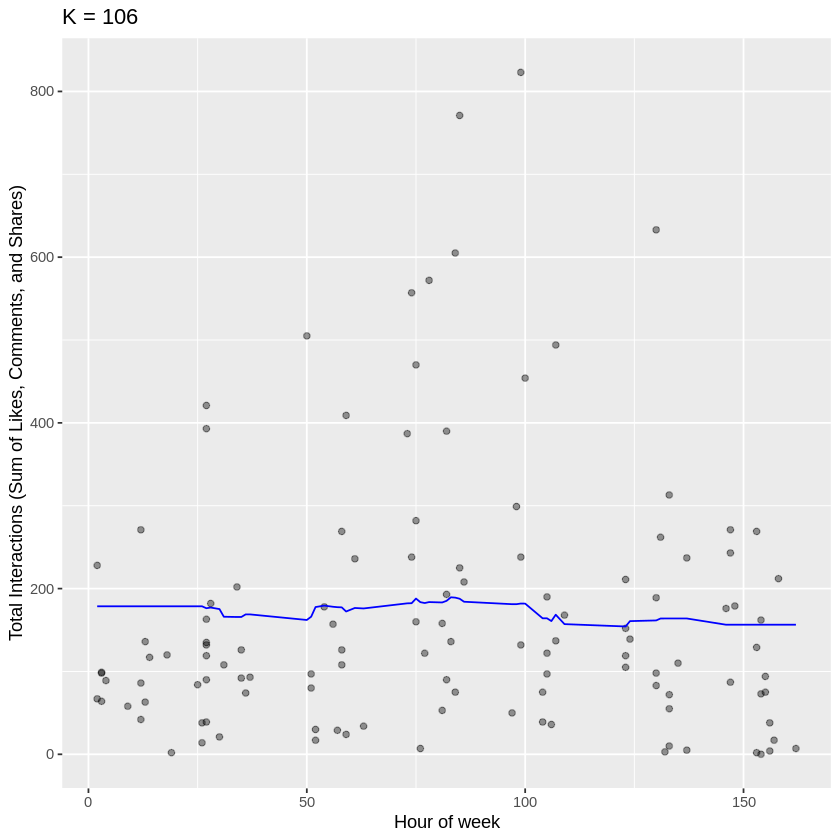

In [40]:
#set.seed(2021)
facebook_preds <-  facebook_best_fit %>%
                   predict(facebook_test) %>%
                   bind_cols(facebook_test)
facebook_preds
facebook_plot_final <- ggplot(facebook_preds, aes(x = hour_of_week, y = total_interactions)) +
                       geom_point(alpha = 0.4) +
                       xlab("Hour of week") +
                       ylab("Total Interactions (Sum of Likes, Comments, and Shares)") +
                       geom_line(data = facebook_preds, aes(x = hour_of_week, y = .pred), color = "blue") +
                       ggtitle(paste0("K = ", k_min))
facebook_plot_final

In [41]:
summary(facebook_preds)

     .pred       Page total likes     Type              Category    
 Min.   :154.3   Min.   : 81370   Length:120         Min.   :1.000  
 1st Qu.:163.5   1st Qu.:103580   Class :character   1st Qu.:1.000  
 Median :176.3   Median :128032   Mode  :character   Median :2.000  
 Mean   :171.5   Mean   :120672                      Mean   :1.775  
 3rd Qu.:178.7   3rd Qu.:136393                      3rd Qu.:2.250  
 Max.   :189.5   Max.   :139441                      Max.   :3.000  
                                                                    
   Post Month        post_day       post_hour       Paid       
 Min.   : 1.000   Min.   :1.000   Min.   : 1   Min.   :0.0000  
 1st Qu.: 3.000   1st Qu.:2.000   1st Qu.: 3   1st Qu.:0.0000  
 Median : 7.000   Median :4.000   Median : 9   Median :0.0000  
 Mean   : 6.692   Mean   :4.058   Mean   : 8   Mean   :0.3083  
 3rd Qu.:10.000   3rd Qu.:6.000   3rd Qu.:12   3rd Qu.:1.0000  
 Max.   :12.000   Max.   :7.000   Max.   :19   Max.   :1.0000  


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.611589e+02
rsq,standard,1.174392e-03
mae,standard,1.171512e+02


.pred,Page total likes,Type,Category,Post Month,post_day,post_hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,⋯,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,total_interactions,hour_of_week
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
173.7486,139441,Photo,3,12,3,3,0,2413,4373,⋯,113,154,2812,1503,132,0,66,14,80,51
177.0925,139441,Photo,2,12,2,3,0,7244,13594,⋯,410,580,6228,3200,396,19,325,49,393,27
172.7733,138414,Status,2,12,3,10,0,10060,19680,⋯,1209,1425,17272,8548,1162,4,86,18,108,58
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
165.9462,85979,Link,1,1,5,11,0,45920,5808,⋯,655,763,15766,10720,220,0,128,9,137,107
166.3642,81370,Photo,2,1,5,8,0,3480,6229,⋯,508,687,3961,2104,301,0,53,22,75,104
169.2901,81370,Photo,3,1,4,11,0,4156,7564,⋯,574,832,4534,2452,370,7,91,38,136,83


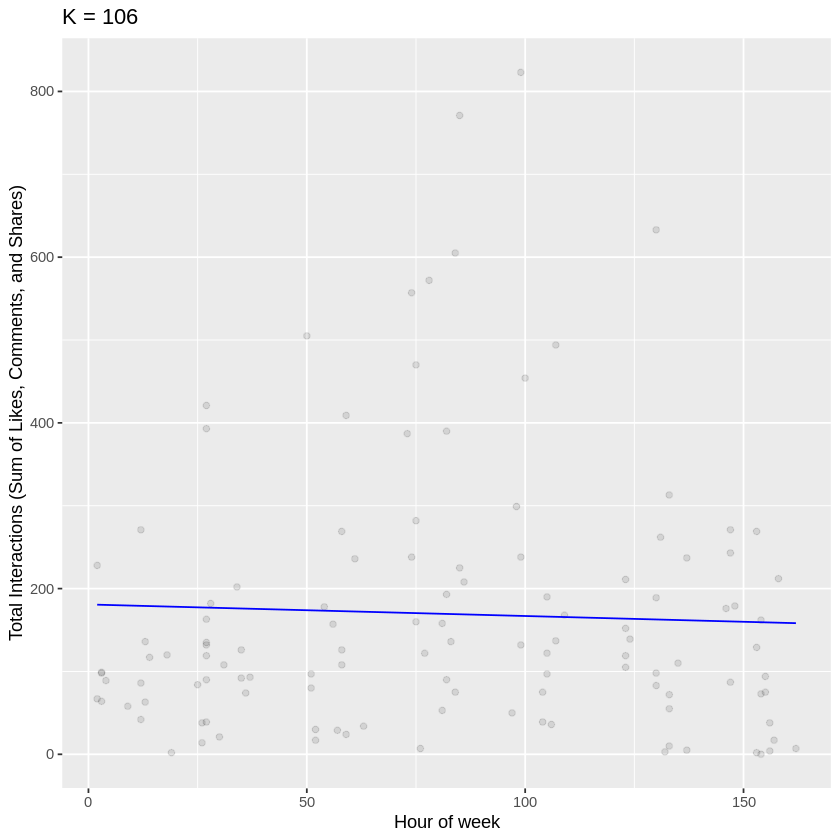

In [42]:
fb_spec <- linear_reg() %>%
    set_engine("lm") %>%
    set_mode("regression")

fb_recipe <- recipe(total_interactions ~ hour_of_week, data = facebook_train)

fb_fit <- workflow() %>%
    add_recipe(fb_recipe) %>%
    add_model(fb_spec) %>%
    fit(data = facebook_train)

fb_test_results <- fb_fit %>%
    predict(facebook_test) %>%
    bind_cols(facebook_test) %>%
    metrics(truth = total_interactions, estimate = .pred)
fb_test_results

facebook_linear_preds <- fb_fit %>%
                   predict(facebook_test) %>%
                   bind_cols(facebook_test)
facebook_linear_preds
facebook_plot_final <- ggplot(facebook_linear_preds, aes(x = hour_of_week, y = total_interactions)) +
                       geom_point(alpha = 0.1) +
                       xlab("Hour of week") +
                       ylab("Total Interactions (Sum of Likes, Comments, and Shares)") +
                       geom_line(data = facebook_linear_preds, aes(x = hour_of_week, y = .pred), color = "blue") +
                       ggtitle(paste0("K = ", k_min))
facebook_plot_final